William Savran <br>
10/26/2018

# Notes on the N-test


The N-test evaluates how well an earthquake forecast matches the observed number of events in a catalog [Zechar et al., 2010]. Here, we have modified the N-test as described by Zechar et al. [2010] to accomodate forecasts that produce stochastic event sets. Conceptually, the tests are identical, but in practice, this modification means we have removed the Poisson assumption required for CSEP1 evaluations by replacing the Poisson test distribution from Zechar et al. [2010] with an empirical distribution estimated from a stochastic event set. See Zechar et al. [2010] for an in-depth explanation of the N-test defined in CSEP1.


In CSEP2, we define an earthquake forecast through a stochastic event set, which is defined as the collection of $N$ synthetic catalogs produced by a single model. Each catalog in the stochastic event set should have identical model configurations, so that the catalogs represent individual realizations from the stochastic event set. At minimum the synthetic catalogs should contain the date-time, magnitude, and $(x,y)$ hypocenter locations for each forecasted event.

The power of a statistical evaluation is defined as the ability to correctly reject an incorrect null hypothesis. The N-test defined for stochastic event sets answers the following questions: (1) Given the empirical distribution of event counts, what is the probability of observing at most $N_{obs}$ earthquakes, and (2) given the empirical distribution of event counts, what is the probability of observing more than $N_{obs}$ events. Here, $N_{obs}$ is the number of events in the observed catalog. 

An important trait for a useful evaluation of an earthquake forecast is the ability to distinguish between similar models, such as UCERF3-ETAS versus UCERF3-NoFaults. An evaluation should be able to correctly distinguish an incorrect hypothesis with high likelihood. In the following sections, we will simulate the power of the N-test using these two aforementioned forecasts. In developing new tests for CSEP2, we should look to optimize the power of the tests employed, so that experimental questions can be answered with confidence.

The power of a statistical test is the probability of properly rejecting an incorrect null hypothesis. As shown by Zechar et al. [2010], we can simulate the power of a statistical test using the following approach (with slight modifications for stocahstic event sets): (1) given two forecasts (in this case UCERF3-ETAS and UCERF3-NoFaults), we will assume that one event-count forecast $\Lambda_1$ represents the 'true' generator of seismicity and $\Lambda_2$ represents the forecasted seismicity. Since both forecasts are stochastic event sets, we can sample $\Lambda_1$ and perform the N-test against $\Lambda_2$ for each catalog sampled from $\Lambda_1$.

This will generate two data products: (1) the quantile score $\gamma$ which can be used as a basis for rejection based on the significance level $\alpha$ and (2) the distribution of p-values produced from the evaluations. We can say the power of the test is related to (1) which is the fraction of test results that properly reject the null hypothesis at some significance level $\alpha$. 

## N-Test implementation

General algorithm for N-tests on stocahstic event sets; taken from the shared document.

As regards the N-test, it could be replaced by this test. (The null hypothesis remains the same).
* We sum the total number of earthquakes occurred, $M_{obs}$.
* We count the same quantity in each simulated catalog to get $M_{obs(s)}$ where the index s indicates the s-th simulated catalog. The set of $M_{obs(s)}$ allows us to build numerically the distribution of M, given the model is 'true'. 
* The test compares $M_{obs(s)}$ with the empirical distribution, i.e., the P-value of the test is the percentile of the empirical distribution smaller/larger than $M_{obs(s)}$.

##### **Note:** The cells need to be executed in order, because some variables are overwritten by later cells.


In [1]:
import time
import os
import csep
import csep.utils.plotting
import csep.core.evaluations
from csep.utils.stats import ecdf
%pylab inline

# Minimum Magnitude for Catalogs
mw_min = 2.95

# Significance for rejection 
alpha = 0.05

# two-sided test
tol = alpha / 2.0

# For Comcat catalog
epoch_time = 709732655000
duration_in_years = 1.0

# Filenames of target simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

Populating the interactive namespace from numpy and matplotlib


### Load Comcat Catalog and Stocahstic Event Set

In [2]:
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude > {}'.format(mw_min))
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {:.2f} and Max Latitude: {:.2f}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {:.2f} and Max Longitude: {:.2f}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {:.2f} and Max Magnitude: {:.2f}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 3.3082239627838135 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-06-26 12:48:33.792000+00:00
Min Latitude: 31.61 and Max Latitude: 41.84
Min Longitude: -125.21 and Max Longitude: -113.18
Min Magnitude: 2.96 and Max Magnitude: 6.30



In [3]:
# Load Stocahstic Event Set
t0 = time.time()
u3catalogs = csep.load_stochastic_event_set(filename=filename, type='ucerf3', format='native', name='UCERF3-ETAS')
# Example of functional programming to apply function to stochastic event set
u3catalogs_filt = list(map(lambda x: x.filter('magnitude > {}'.format(mw_min)), u3catalogs))
t1 = time.time()
print('Loaded {} UCERF3 catalogs in {} seconds.\n'.format(len(u3catalogs_filt), (t1-t0)))

Loaded 10000 UCERF3 catalogs in 22.16463828086853 seconds.



### Get cumulative distributions

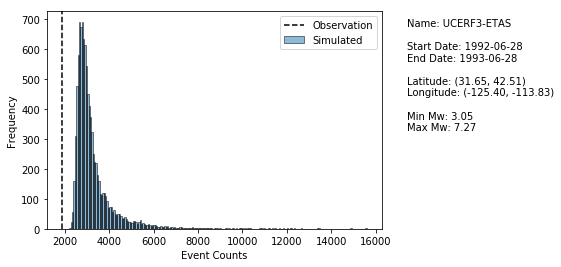

In [4]:
sim_counts = [catalog.get_number_of_events() for catalog in u3catalogs_filt]
comcat_count = comcat.get_number_of_events()

ax = csep.utils.plotting.plot_histogram(sim_counts, comcat_count, 
                                   catalog=u3catalogs_filt[0], 
                                   plot_args={'xlabel': 'Event Counts'})

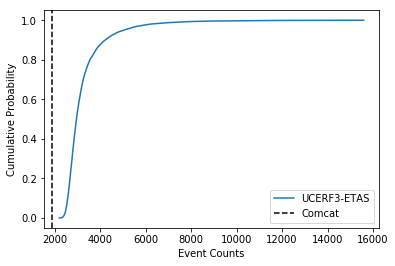

In [5]:
x, cdf = ecdf(sim_counts)
fig, ax = subplots()
ax.plot(x, cdf, label='UCERF3-ETAS')
xlabel('Event Counts')
ylabel('Cumulative Probability')
axvline(x=comcat_count, color='black', linestyle='--', label='Comcat')
legend(loc='best')

In [6]:
def greater_equal_ecdf(x, val):
    """
    Given val return P(x ≥ val).

    Args:
        x (numpy.array): set of values
        val (float): value

    Returns:
        (float): probability that x ≤ val
    """
    x = numpy.asarray(x)
    ex, ey = ecdf(x)
    eyc = ey[::-1]
    # some short-circuit cases for discrete distributions
    if val > numpy.max(x):
        return 0.0
    if val < numpy.min(x):
        return 1.0
    return eyc[numpy.searchsorted(ex, val)]

def less_equal_ecdf(x, val):
    """
    Given val return P(x ≤ val).

    Args:
        x (numpy.array): set of values
        val (float): value

    Returns:
        (float): probability that x ≤ val
    """
    x = numpy.asarray(x)
    ex, ey = ecdf(x)
    # some short-circuit cases for discrete distributions
    if val > numpy.max(x):
        return 1.0
    if val < numpy.min(x):
        return 0.0
    return ey[numpy.searchsorted(ex,val,side='right')-1]


### Putting it Together: The N-Test

We can put evaluations into two main categories. Those which a single statistic is estimated from a catalog versus those were a distribution are estimated. The N-Test represents an example of the former, where as the MFD represents the latter.

In [7]:
def number_test(stochastic_event_set, observation):
    """
    Perform an N-Test on a stochastic event set and observation.
    
    Note: 
        Arguments must implement get_number_of_events() method for this function to work.
    """
    # get number of events for observations and simulations
    sim_counts = []
    for catalog in stochastic_event_set:
        sim_counts.append(catalog.get_number_of_events())
    observation_count = observation.get_number_of_events()
    # delta 1
    delta_1 = greater_equal_ecdf(sim_counts, observation_count)
    delta_2 = less_equal_ecdf(sim_counts, observation_count)
    
    return (delta_1, delta_2)

In [8]:
p_value = number_test(u3catalogs_filt, comcat)
print(r'd1={} and d2={}'.format(*p_value))

d1=1.0 and d2=0.0


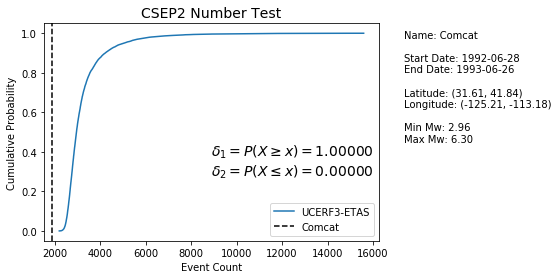

In [9]:
from csep.core.evaluations import number_test as csep_number_test

result, ax = csep_number_test(u3catalogs_filt, comcat, plot=True, plot_args={'show': True})

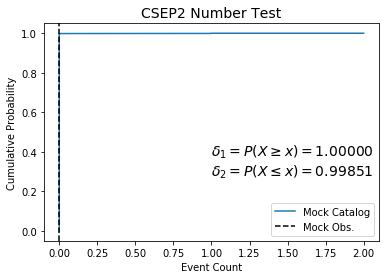

In [33]:
# test forecast where counts are mostly zero, following thought experiment in 
# zechar et al., 2010
from csep.core.evaluations import number_test as csep_number_test
n_obs = 0
rate = 0.0015
ints=random.poisson(lam=rate, size=5000000)

class MockCatalog:
    """
    Mock catalog class for testing purposes
    """
    def __init__(self, val, name='Mock Catalog'):
        self.val = val
        self.name = name
        
    def __str__(self):
        return ''

    def get_number_of_events(self):
        return self.val

sets = [MockCatalog(val) for val in ints]
obs = MockCatalog(n_obs, 'Mock Obs.')

result, ax = csep_number_test(sets, obs, plot=True, plot_args={'show': True})

## On the Power of the N-test
In the preliminary versions of this analysis, we assume that $\alpha=0.05$ and UCERF3-ETAS represents the 'true' event-count forecast. We will filter out events with $M_w < 3.95$ to provide some computational performance. We show the implementation of the procedure below.

##### **Note:** The cells need to be executed in order, because some variables are overwritten by later cells.

### Load Catalogs


In [11]:
u3nofaults_filt = []
t0 = time.time()
u3nofaults = csep.load_stochastic_event_set(filename=filename_nofaults, type='ucerf3', format='native', name='UCERF3-ETAS')
for u3nofault in u3nofaults:
    u3nofaults_filt.append(u3nofault.filter('magnitude > {}'.format(mw_min)))
t1 = time.time()
print('Loaded {} UCERF3 catalogs in {} seconds.\n'.format(len(u3nofaults_filt), (t1-t0)))

Loaded 10000 UCERF3 catalogs in 22.27287793159485 seconds.



### Compute N-test and Build Distributions

Recall, we are assuming that model $\Lambda_1$ repesents the 'true' distribution of simulated seismiscity. This means  we are going to treat the *i*-th synthetic catalog, $\Lambda_1^i$ from $\Lambda_1$ as if it were data. We are going to estimate a p-value from the N-test for the distribution estimated from $\Lambda_2$.

We are going to perform the N-test at the 95% confidence limit. For all of the following tests, $\alpha=0.05$.

#### $\Lambda_1$ = UCERF3-ETAS; $\Lambda_2$ = UCERF3-NoFaults

In [12]:
n_sim = 10000
n_cats = len(u3catalogs_filt)
p_values = []
results = []

for i in range(n_sim):
    true_catalog = u3catalogs_filt[i]
    
    # perform n-test
    p_value, ax = csep_number_test(u3nofaults_filt, true_catalog)
    p_values.append(p_value)
    
    # Rejected == 1 and Fail to reject == 0
    if p_value[0] < tol or p_value[1] < tol:
        results.append(1)
    else:
        results.append(0)
        

In [13]:
results = array(results)
ax = csep.utils.plotting.plot_histogram(p_values, tol, 
                                        bins='fd', 
                                        catalog=true_catalog, 
                                        plot_args={'legend_loc': 'upper left',
                                                   'xlabel': 'p-value',
                                                   'sim_label': ('$\delta_1$','$\delta_2$'),
                                                   'obs_label': r'$(\alpha/2, 1-\alpha/2)$',
# compute the number of rejected models
rejected = len(argwhere(results==1))
power = rejected / n_cats
print('Rejected {} catalogs out of {} resulting in a power of {:.2f}.'
      .format(rejected, n_cats, power))

SyntaxError: invalid syntax (<ipython-input-13-ed34a277da42>, line 10)

#### $\Lambda_1$ = UCERF3-NoFaults; $\Lambda_2$ = UCERF3-ETAS

In [ ]:
n_sim = 10000
n_cats = len(u3catalogs_filt)
p_values = []
results = []

for i in range(n_sim):
    true_catalog = u3nofaults_filt[i]
    
    # perform n-test
    p_value, ax = csep.core.evaluations.number_test(u3catalogs_filt, true_catalog)
    p_values.append(p_value)
    
    # Rejected == 1 and Fail to reject == 0
    if p_value[0] < tol or p_value[1] < tol:
        results.append(1)
    else:
        results.append(0)

In [ ]:
results = array(results)
ax = csep.utils.plotting.plot_histogram(p_values, tol, 
                                        bins='fd', 
                                        catalog=true_catalog, 
                                        plot_args={'legend_loc': 'upper left',
                                                   'xlabel': 'p-value',
                                                   'sim_label': ('$\delta_1$','$\delta_2$'),
                                                   'obs_label': r'$(\alpha/2, 1-\alpha/2)$',
                                                   'title': 'UCERF3-NoFaults is True'})
rejected = len(argwhere(results==1))
power = rejected / n_cats
print('Rejected {} catalogs out of {} resulting in a power of {:.2f}.'
      .format(rejected, n_cats, power))

#### $\Lambda_1$ = UCERF3-ETAS; $\Lambda_2$ = UCERF3-ETAS

In [ ]:
n_sim = 10000
n_cats = len(u3catalogs_filt)
p_values = []
results = []

for i in range(n_sim):
    true_catalog = u3catalogs_filt[i]
    
    # perform n-test
    p_value, ax = csep.core.evaluations.number_test(u3catalogs_filt, true_catalog)
    p_values.append(p_value)
    
    # Rejected == 1 and Fail to reject == 0
    if p_value[0] < tol or p_value[1] < tol:
        results.append(1)
    else:
        results.append(0)

In [ ]:
results = array(results)
ax = csep.utils.plotting.plot_histogram(p_values, tol, 
                                        bins='fd', 
                                        catalog=true_catalog, 
                                        plot_args={'legend_loc': 'upper left',
                                                   'xlabel': 'p-value',
                                                   'sim_label': 'p-values',
                                                   'obs_label': r'$(\alpha/2, 1-\alpha/2)$',
                                                   'title': 'UCERF3-ETAS is True'})
rejected = len(argwhere(results==1))
power = rejected / n_cats
print('Rejected {} catalogs out of {}.'
      .format(rejected, n_cats, power))

## References
Zechar, J. D., Gerstenberger, M. C., & Rhoades, D. A. (2010). Likelihood-based tests for evaluating space–rate–magnitude earthquake forecasts. Bulletin of the Seismological Society of America, 100(3), 1184-1195.